In [1]:
import torch

In [2]:
torch.version.cuda

'8.0'

In [1]:
import sys
import numpy as np
import keras
from keras.utils import Sequence
from PIL import Image
from matplotlib import pyplot as plt
import pandas as pd
import os
import cv2

C:\Users\Amit\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
BATCH_SIZE = 4
SEED = 777
SHAPE = (192, 192, 4)
DIR = 'E:/Protein'
VAL_RATIO = 0.1 
THRESHOLD = 0.05 

In [3]:
def getTrainDataset():
    
    path_to_train = DIR + '/train/'
    data = pd.read_csv(DIR + '/train.csv')

    paths = []
    labels = []
    
    for name, lbl in zip(data['Id'], data['Target'].str.split(' ')):
        y = np.zeros(28)
        for key in lbl:
            y[int(key)] = 1
        paths.append(os.path.join(path_to_train, name))
        labels.append(y)

    return np.array(paths), np.array(labels)

def getTestDataset():
    
    path_to_test = DIR + '/test/'
    data = pd.read_csv(DIR + '/sample_submission.csv')

    paths = []
    labels = []
    
    for name in data['Id']:
        y = np.ones(28)
        paths.append(os.path.join(path_to_test, name))
        labels.append(y)

    return np.array(paths), np.array(labels)

In [4]:
class ProteinDataGenerator(keras.utils.Sequence):
            
    def __init__(self, paths, labels, batch_size, shape, shuffle = False, use_cache = False, augment = False):
        self.paths, self.labels = paths, labels
        self.batch_size = batch_size
        self.shape = shape
        self.shuffle = shuffle
        self.use_cache = use_cache
        self.augment = augment
        if use_cache == True:
            self.cache = np.zeros((paths.shape[0], shape[0], shape[1], shape[2]), dtype=np.float16)
            self.is_cached = np.zeros((paths.shape[0]))
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.paths) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        indexes = self.indexes[idx * self.batch_size : (idx+1) * self.batch_size]

        paths = self.paths[indexes]
        X = np.zeros((paths.shape[0], self.shape[0], self.shape[1], self.shape[2]))
        # Generate data
        if self.use_cache == True:
            X = self.cache[indexes]
            for i, path in enumerate(paths[np.where(self.is_cached[indexes] == 0)]):
                image = self.__load_image(path)
                self.is_cached[indexes[i]] = 1
                self.cache[indexes[i]] = image
                X[i] = image
        else:
            for i, path in enumerate(paths):
                X[i] = self.__load_image(path)

        y = self.labels[indexes]
                
        if self.augment == True:
            seq = iaa.Sequential([
                iaa.OneOf([
                    iaa.Fliplr(0.5), 
                    iaa.Crop(percent=(0, 0.1)),
                    
                    iaa.Sometimes(0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    
                    iaa.ContrastNormalization((0.75, 1.5)),
                   
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                   
                    iaa.Multiply((0.8, 1.2), per_channel=0.2),
                   
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                        rotate=(-180, 180),
                        shear=(-8, 8)
                    )
                ])], random_order=True)

            X = np.concatenate((X, seq.augment_images(X), seq.augment_images(X), seq.augment_images(X)), 0)
            y = np.concatenate((y, y, y, y), 0)
        
        return X, y
    
    def on_epoch_end(self):
        
        
        self.indexes = np.arange(len(self.paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __iter__(self):
        """Create a generator that iterate over the Sequence."""
        for item in (self[i] for i in range(len(self))):
            yield item
            
    def __load_image(self, path):
        R = Image.open(path + '_red.png')
        G = Image.open(path + '_green.png')
        B = Image.open(path + '_blue.png')
        Y = Image.open(path + '_yellow.png')

        im = np.stack((
            np.array(R), 
            np.array(G), 
            np.array(B),
            np.array(Y)), -1)
        
        im = cv2.resize(im, (SHAPE[0], SHAPE[1]))
        im = np.divide(im, 255)
        return im

In [5]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, Model
from keras.layers import Activation, Dropout, Flatten, Dense, Input, Conv2D, MaxPooling2D, BatchNormalization, Concatenate, ReLU, LeakyReLU
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras import metrics
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K
import keras
import tensorflow as tf



In [6]:
def f1(y_true, y_pred):
   
    y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), THRESHOLD), K.floatx())
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return 1-K.mean(f1)

In [7]:
def create_model(input_shape):
    
    dropRate = 0.25
    
    init = Input(input_shape)
    x = BatchNormalization(axis=-1)(init)
    x = Conv2D(8, (3, 3))(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(8, (3, 3))(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(16, (3, 3))(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(dropRate)(x)
    c1 = Conv2D(16, (3, 3), padding='same')(x)
    c1 = ReLU()(c1)
    c2 = Conv2D(16, (5, 5), padding='same')(x)
    c2 = ReLU()(c2)
    c3 = Conv2D(16, (7, 7), padding='same')(x)
    c3 = ReLU()(c3)
    c4 = Conv2D(16, (1, 1), padding='same')(x)
    c4 = ReLU()(c4)
    x = Concatenate()([c1, c2, c3, c4])
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(dropRate)(x)
    x = Conv2D(32, (3, 3))(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(dropRate)(x)
    x = Conv2D(64, (3, 3))(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(dropRate)(x)
    x = Conv2D(128, (3, 3))(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(dropRate)(x)
   
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(28)(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = Dropout(0.1)(x)
    x = Dense(28)(x)
    x = Activation('sigmoid')(x)
    
    model = Model(init, x)
    
    return model

In [8]:
model = create_model(SHAPE)
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(1e-03),
    metrics=['acc',f1])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 192, 192, 4)  0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 192, 192, 4)  16          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 190, 190, 8)  296         batch_normalization_1[0][0]      
__________________________________________________________________________________________________
re_lu_1 (ReLU)       

In [9]:
paths, labels = getTrainDataset()


keys = np.arange(paths.shape[0], dtype=np.int)  
np.random.seed(SEED)
np.random.shuffle(keys)
lastTrainIndex = int((1-VAL_RATIO) * paths.shape[0])

pathsTrain = paths[0:lastTrainIndex]
labelsTrain = labels[0:lastTrainIndex]
pathsVal = paths[lastTrainIndex:]
labelsVal = labels[lastTrainIndex:]

print(paths.shape, labels.shape)
print(pathsTrain.shape, labelsTrain.shape, pathsVal.shape, labelsVal.shape)

tg = ProteinDataGenerator(pathsTrain, labelsTrain, BATCH_SIZE, SHAPE, use_cache=True, augment = False, shuffle = False)
vg = ProteinDataGenerator(pathsVal, labelsVal, BATCH_SIZE, SHAPE, use_cache=True, shuffle = False)


checkpoint = ModelCheckpoint('./base.model', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='min', period=1)
reduceLROnPlato = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, mode='min')

(31072,) (31072, 28)
(27964,) (27964, 28) (3108,) (3108, 28)


In [10]:
epochs = 2

use_multiprocessing = False # DO NOT COMBINE MULTIPROCESSING WITH CACHE! 
workers = 1 # DO NOT COMBINE MULTIPROCESSING WITH CACHE! 

hist = model.fit_generator(
    tg,
    steps_per_epoch=len(tg),
    validation_data=vg,
    validation_steps=8,
    epochs=epochs,
    use_multiprocessing=use_multiprocessing,
    workers=workers,
    verbose=1,
    callbacks=[checkpoint])

Instructions for updating:
Use tf.cast instead.
Epoch 1/2
6991/6991 [==============================] - 11632s 2s/step - loss: 0.1912 - acc: 0.9330 - f1: 0.0764 - val_loss: 0.1624 - val_acc: 0.9442 - val_f1: 0.0809

Epoch 00001: val_loss improved from inf to 0.16236, saving model to ./base.model
Epoch 2/2
6991/6991 [==============================] - 11077s 2s/step - loss: 0.1670 - acc: 0.9443 - f1: 0.0797 - val_loss: 0.1845 - val_acc: 0.9375 - val_f1: 0.0747

Epoch 00002: val_loss did not improve from 0.16236


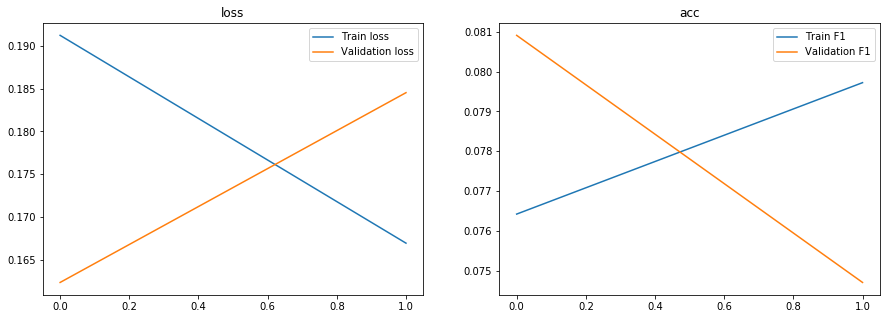

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].set_title('loss')
ax[0].plot(hist.epoch, hist.history["loss"], label="Train loss")
ax[0].plot(hist.epoch, hist.history["val_loss"], label="Validation loss")
ax[1].set_title('acc')
ax[1].plot(hist.epoch, hist.history["f1"], label="Train F1")
ax[1].plot(hist.epoch, hist.history["val_f1"], label="Validation F1")
ax[0].legend()
ax[1].legend()

In [13]:
bestModel = load_model('./base.model', custom_objects={'f1': f1})

In [14]:
fullValGen = vg

In [19]:
from tqdm import tqdm
lastFullValPred = np.empty((0, 28))
lastFullValLabels = np.empty((0, 28))
for i in tqdm(range(len(fullValGen))): 
    im, lbl = fullValGen[i]
    scores = bestModel.predict(im)
    lastFullValPred = np.append(lastFullValPred, scores, axis=0)
    lastFullValLabels = np.append(lastFullValLabels, lbl, axis=0)
print(lastFullValPred.shape, lastFullValLabels.shape)

100%|████████████████████████████████████████████████████████████████████████████████| 777/777 [05:56<00:00,  1.11it/s]


(3108, 28) (3108, 28)


In [20]:
from sklearn.metrics import f1_score as off1
rng = np.arange(0, 1, 0.001)
f1s = np.zeros((rng.shape[0], 28))
for j,t in enumerate(tqdm(rng)):
    for i in range(28):
        p = np.array(lastFullValPred[:,i]>t, dtype=np.int8)
        scoref1 = off1(lastFullValLabels[:,i], p, average='binary')
        f1s[j,i] = scoref1

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]C:\Users\Amit\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
  0%|▏                                                                                | 2/1000 [00:00<01:03, 15.82it/s]C:\Users\Amit\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:31<00:00, 30.93it/s]


In [21]:
print('Individual F1-scores for each class:')
print(np.max(f1s, axis=0))
print('Macro F1-score CV =', np.mean(np.max(f1s, axis=0)))

Individual F1-scores for each class:
[0.58576052 0.08336047 0.22472755 0.14104372 0.19512195 0.18818182
 0.11084337 0.18473896 0.00963855 0.00391134 0.00128617 0.13545817
 0.13986014 0.04347826 0.20143885 0.0030722  0.04848485 0.01987353
 0.05811808 0.11517814 0.01081081 0.43572621 0.08663181 0.19578947
 0.03625378 0.57572614 0.02849604 0.        ]
Macro F1-score CV = 0.13796467521892872


Probability threshold maximizing CV F1-score for each class:
[0.365 0.024 0.137 0.107 0.133 0.084 0.044 0.099 0.002 0.001 0.    0.039
 0.03  0.024 0.04  0.001 0.018 0.007 0.025 0.054 0.005 0.111 0.021 0.095
 0.016 0.191 0.01  0.   ]


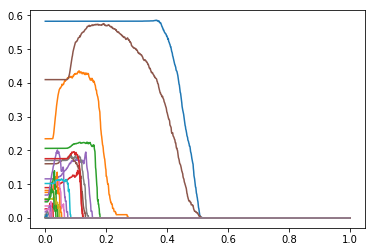

In [22]:
plt.plot(rng, f1s)
T = np.empty(28)
for i in range(28):
    T[i] = rng[np.where(f1s[:,i] == np.max(f1s[:,i]))[0][0]]
print('Probability threshold maximizing CV F1-score for each class:')
print(T)

In [23]:
pathsTest, labelsTest = getTestDataset()

testg = ProteinDataGenerator(pathsTest, labelsTest, BATCH_SIZE, SHAPE)
submit = pd.read_csv(DIR + '/sample_submission.csv')
P = np.zeros((pathsTest.shape[0], 28))
for i in tqdm(range(len(testg))):
    images, labels = testg[i]
    score = bestModel.predict(images)
    P[i*BATCH_SIZE:i*BATCH_SIZE+score.shape[0]] = score

100%|██████████████████████████████████████████████████████████████████████████████| 2926/2926 [40:32<00:00,  1.66it/s]


In [24]:
PP = np.array(P)

In [25]:
prediction = []

for row in tqdm(range(submit.shape[0])):
    
    str_label = ''
    
    for col in range(PP.shape[1]):
        if(PP[row, col] < T[col]):
            str_label += ''
        else:
            str_label += str(col) + ' '
    prediction.append(str_label.strip())
    
submit['Predicted'] = np.array(prediction)
submit.to_csv('4channels_cnn_from_scratch.csv', index=False)

100%|█████████████████████████████████████████████████████████████████████████| 11702/11702 [00:00<00:00, 37984.88it/s]
